In [1]:
# Data handling
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

# Imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Modeling
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

# Metrics & evaluation
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")


In [15]:
# Load dataset
data = pd.read_csv("fraudTest.csv")

# Quick check
data.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [16]:
# Drop columns with too many categories or not useful
data = data.drop(columns=[
    "cc_num", "first", "last", "street",
    "trans_num", "trans_date_trans_time",
    "job", "merchant"
])


In [ ]:
# Label encode gender
le_gender = LabelEncoder()
data['gender'] = le_gender.fit_transform(data['gender'])

# One-hot encode 'category' and 'state'
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

cat_features = data[['category', 'state']]

ohe_encoded = ohe.fit_transform(data[cat_features])

# Convert back to DataFrame with proper column names
ohe_df = pd.DataFrame(
    ohe_encoded,
    columns=ohe.get_feature_names_out(['category', 'state']),
    index=data.index
)

# Concatenate back to dataset and drop originals
data = pd.concat([data.drop(columns=['category', 'state']), ohe_df], axis=1)
data = data.drop(columns=['Unnamed: 0', 'city', 'zip', 'dob'])

In [8]:
# Split X / y
y = data['is_fraud'].astype(int)
X = data.drop(columns=['is_fraud'])

# Train / test (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale continuous numeric columns
num_cols = ['amt','lat','long','city_pop','unix_time','merch_lat','merch_long']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

# Downcast to save RAM
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')


In [9]:

# Build the ANN model
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),
    Dense(64),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = 'binary_crossentropy'
metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')]

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         9,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,409 (68.00 KB)

 Trainable params: 17,409 (68.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tabnanny import verbose


early_stopping = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=20,
    restore_best_weights=True
)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=200, batch_size=2048, verbose=0,
          callbacks=[early_stopping])


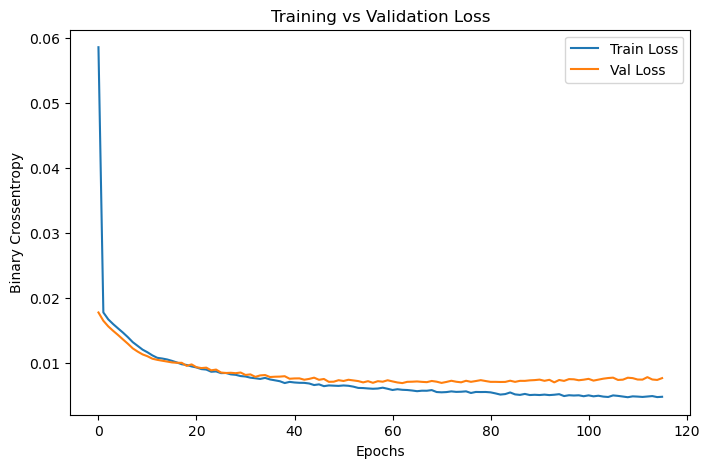

In [11]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(history.history['loss'], label='Train Loss')
ax.plot(history.history['val_loss'], label='Val Loss')

ax.set_xlabel('Epochs')
ax.set_ylabel('Binary Crossentropy')
ax.set_title('Training vs Validation Loss')
ax.legend()

plt.show()

3474/3474 ━━━━━━━━━━━━━━━━━━━━ 2s 535us/step


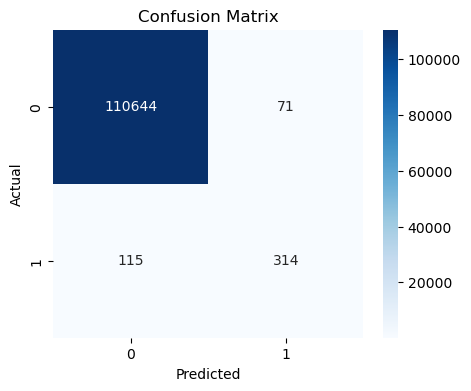

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110715
           1       0.82      0.73      0.77       429

    accuracy                           1.00    111144
   macro avg       0.91      0.87      0.89    111144
weighted avg       1.00      1.00      1.00    111144

ROC-AUC: 0.9896267606604959


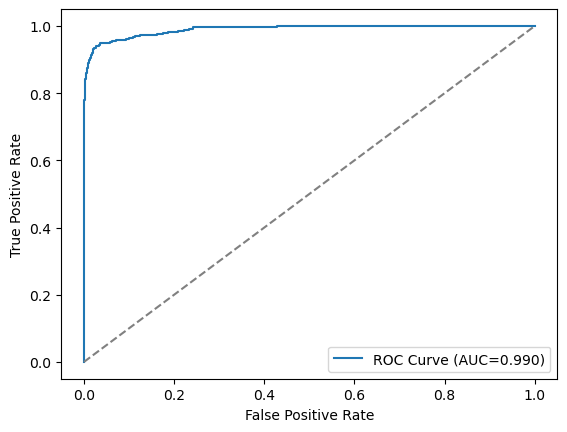

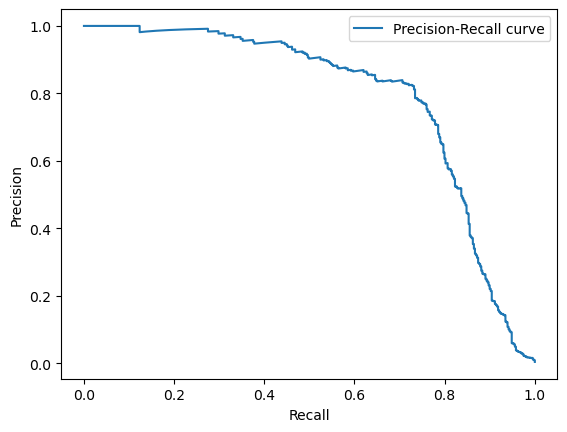

In [12]:
# Predict probabilities
y_pred_proba = model.predict(X_test).ravel()
# Convert to class labels with threshold 0.5
y_pred = (y_pred_proba >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report (precision, recall, f1)
print(classification_report(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC:", roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(rec, prec, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()
